In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import joblib
from sklearn.ensemble import RandomForestRegressor

In [4]:
data = pd.read_csv("/content/avito.csv")
data

,SalleDeBain,surface,chambres,salons,Secteur,price
0,1,101,2,2,Aïn Borja,990000
1,2,126,3,2,Maarif,2200000
2,2,81,2,1,Sidi Bernoussi,840000
3,2,100,2,2,Bourgogne,1100000
4,2,63,2,1,Autre secteur,680000
...,...,...,...,...,...,...
5487,1,92,3,1,Hay Albaraka,510000
5488,2,90,2,2,Laimoune,980000
5489,1,64,2,1,Sidi Moumen,500000
5490,2,129,2,2,Roches Noires,1200000


Explore the relationship between the price of properties and their surface area

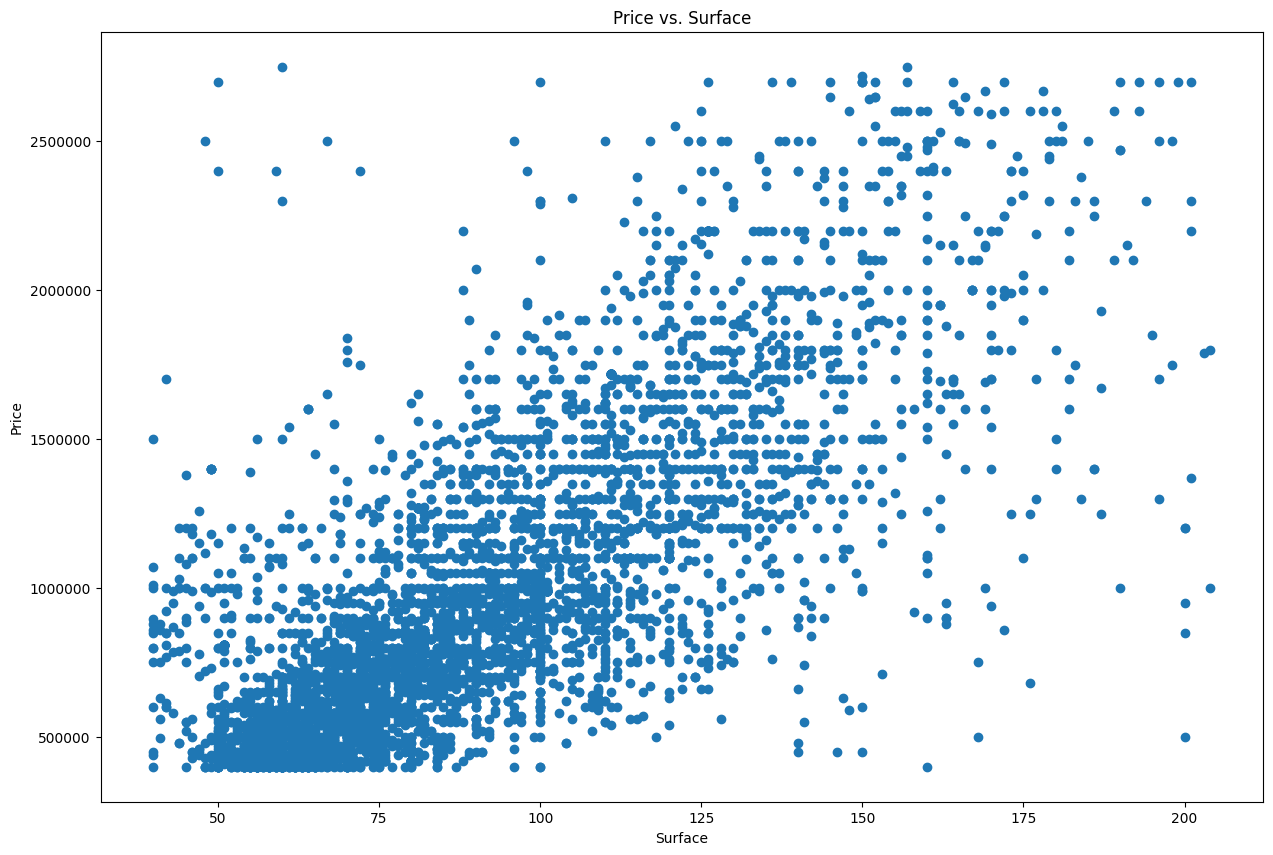

In [11]:
plt.figure(figsize=(15, 10))
plt.scatter(data['surface'], data['price'])
plt.xlabel('Surface')
plt.ylabel('Price')
plt.title('Price vs. Surface')
plt.ticklabel_format(style='plain', axis='y')
plt.show()


Visualize the distribution of prices to understand the range and frequency of prices in the dataset.

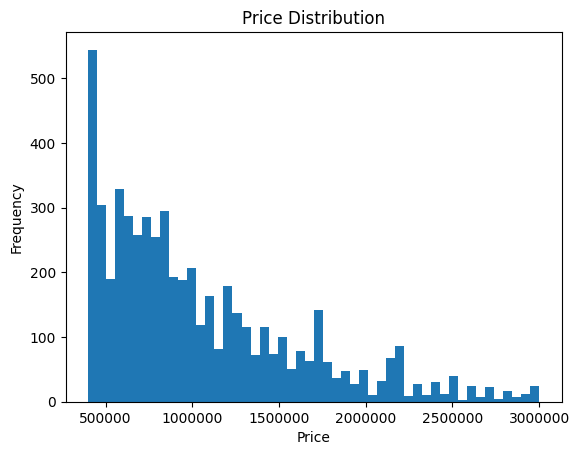

In [ ]:
plt.hist(data['price'], bins=50)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution')
plt.ticklabel_format(style='plain', axis='x')
plt.show()


Calculate the average price for each sector and visualize it using a bar chart.

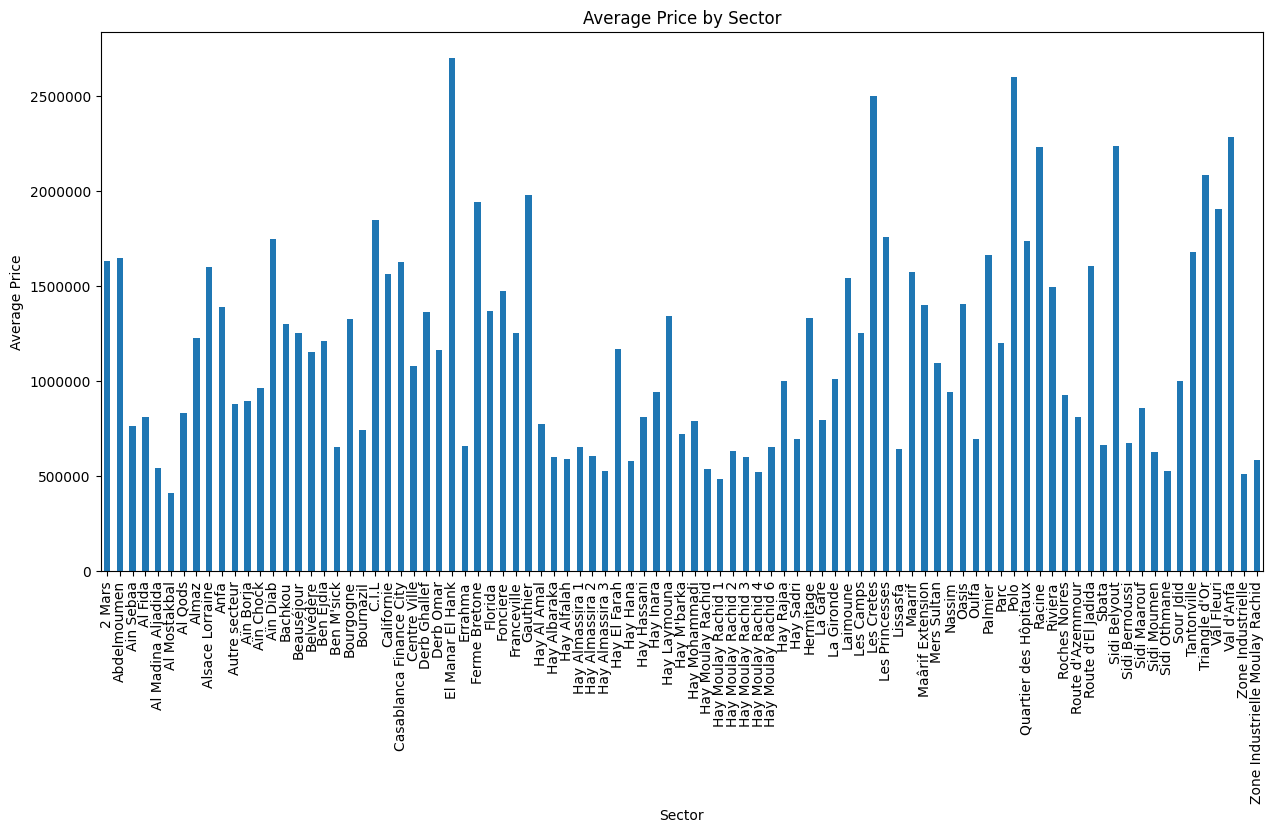

In [ ]:
plt.figure(figsize=(15, 7))

average_price_by_sector = data.groupby('Secteur')['price'].mean()
average_price_by_sector.plot(kind='bar')
plt.xlabel('Sector')
plt.ylabel('Average Price')
plt.title('Average Price by Sector')
plt.ticklabel_format(style='plain', axis='y')

plt.show()

number of pro per secteur

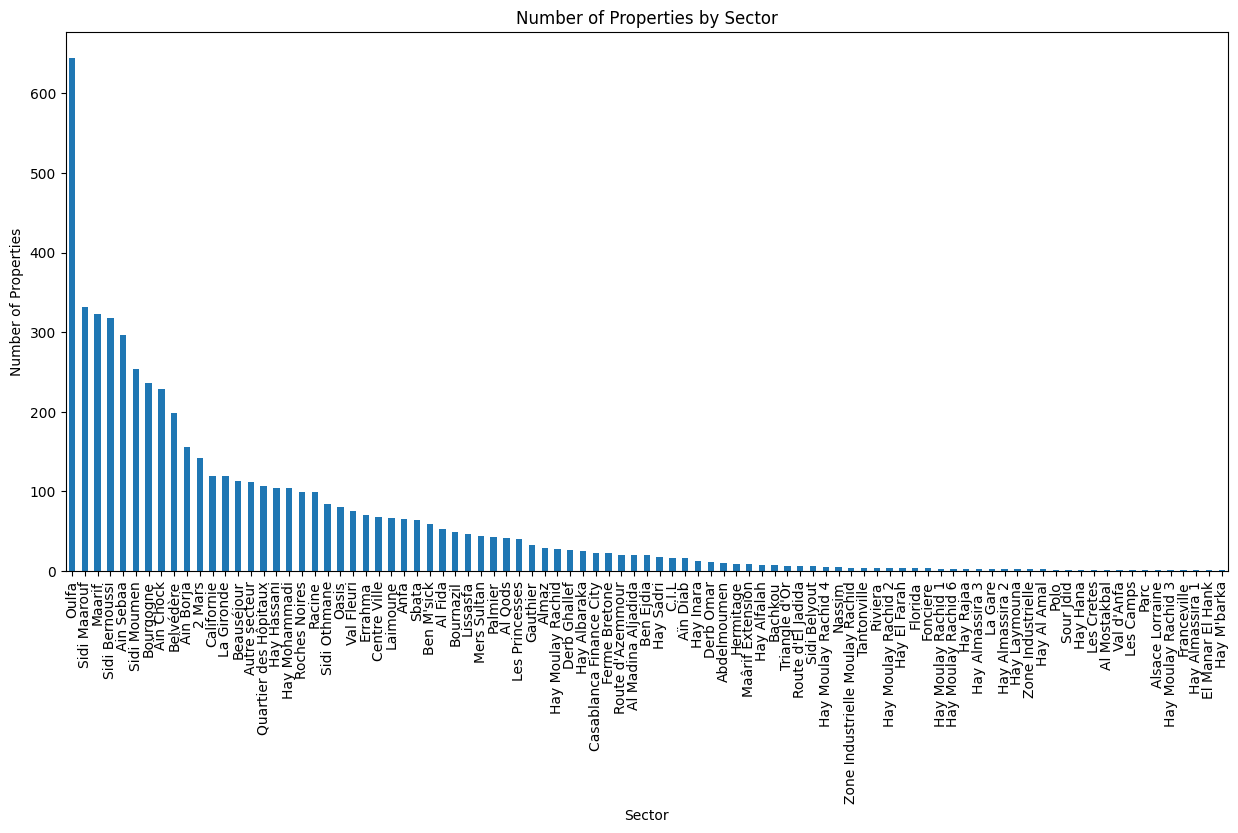

In [ ]:
plt.figure(figsize=(15, 7))
property_count_by_sector = data['Secteur'].value_counts()
property_count_by_sector.plot(kind='bar')
plt.xlabel('Sector')
plt.ylabel('Number of Properties')
plt.title('Number of Properties by Sector')
plt.ticklabel_format(style='plain', axis='y')

plt.show()

pice trend over surface

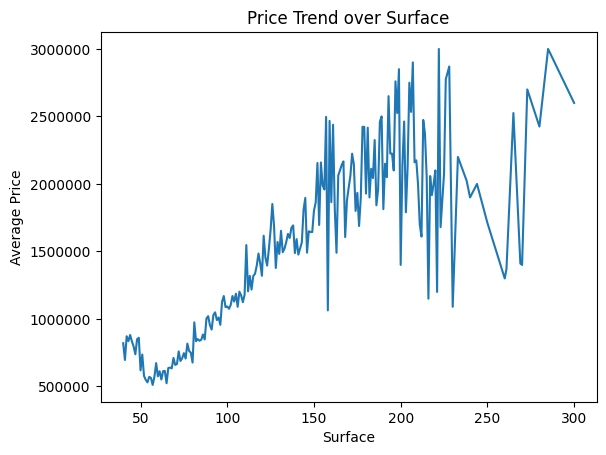

In [ ]:
average_price_by_surface = data.groupby('surface')['price'].mean()
average_price_by_surface.plot()
plt.xlabel('Surface')
plt.ylabel('Average Price')
plt.title('Price Trend over Surface')
plt.ticklabel_format(style='plain', axis='y')

plt.show()

In [6]:
data.info()
data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5492 entries, 0 to 5491
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   SalleDeBain  5492 non-null   int64 
 1   surface      5492 non-null   int64 
 2   chambres     5492 non-null   int64 
 3   salons       5492 non-null   int64 
 4   Secteur      5492 non-null   object
 5   price        5492 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 257.6+ KB


,SalleDeBain,surface,chambres,salons,price
count,5492.000000,5492.000000,5492.000000,5492.000000,5.492000e+03
mean,1.574108,95.724690,2.366715,1.310452,1.046333e+06
std,0.608451,36.280288,0.739823,0.551100,5.688363e+05
min,1.000000,40.000000,1.000000,1.000000,4.000000e+05
25%,1.000000,69.000000,2.000000,1.000000,6.100000e+05
50%,2.000000,86.000000,2.000000,1.000000,8.700000e+05
75%,2.000000,114.000000,3.000000,2.000000,1.320000e+06
max,6.000000,300.000000,10.000000,7.000000,3.000000e+06


remove outliers

In [7]:
data = pd.read_csv("/content/avito.csv")
data

columns_to_check = ['SalleDeBain', 'surface', 'chambres', 'salons', 'price']

def remove_outliers_zscore(df, columns):
    threshold = 3
    z_scores = np.abs(stats.zscore(df[columns]))
    df_out = df[(z_scores < threshold).all(axis=1)]
    return df_out

data_no_outliers = remove_outliers_zscore(data, columns_to_check)


data_no_outliers.to_csv('cleaned_dataset.csv', index=False)


In [8]:
data = pd.read_csv("/content/cleaned_dataset.csv")
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5163 entries, 0 to 5162
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   SalleDeBain  5163 non-null   int64 
 1   surface      5163 non-null   int64 
 2   chambres     5163 non-null   int64 
 3   salons       5163 non-null   int64 
 4   Secteur      5163 non-null   object
 5   price        5163 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 242.1+ KB


,SalleDeBain,surface,chambres,salons,price
count,5163.000000,5163.000000,5163.000000,5163.000000,5.163000e+03
mean,1.528762,91.304280,2.295177,1.232423,9.898867e+05
std,0.564424,30.308765,0.620917,0.422418,5.104785e+05
min,1.000000,40.000000,1.000000,1.000000,4.000000e+05
25%,1.000000,68.000000,2.000000,1.000000,6.000000e+05
50%,1.000000,84.000000,2.000000,1.000000,8.500000e+05
75%,2.000000,110.000000,3.000000,1.000000,1.250000e+06
max,3.000000,204.000000,4.000000,2.000000,2.750000e+06


DecisionTreeRegressor

In [ ]:

X = data.drop(columns=['price'])
y = data['price']

categorical_features = ['Secteur']
numerical_features = ['SalleDeBain', 'surface', 'chambres', 'salons']

numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

param_grid = {
    'regressor__max_depth': [None, 3, 5, 7, 10],
    'regressor__min_samples_split': [2, 5, 10, 20],
    'regressor__min_samples_leaf': [1, 2, 4, 8],
    'regressor__max_features': ['auto', 'sqrt', 'log2', None]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

secteur = 'Sidi Bernoussi'
surface = 81
chambres = 2
salledebain = 2
salons = 1

input_data = pd.DataFrame({
    'Secteur': [secteur],
    'SalleDeBain': [salledebain],
    'surface': [surface],
    'chambres': [chambres],
    'salons': [salons]
})

predicted_price = best_model.predict(input_data)

print("Predicted price for the input features:")
print("Secteur:", secteur)
print("Surface:", surface)
print("Chambres:", chambres)
print("Salle de Bain:", salledebain)
print("Salons:", salons)
print("Predicted Price:", predicted_price[0])


Best parameters: {'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 10}
Predicted price for the input features:
Secteur: Sidi Bernoussi
Surface: 81
Chambres: 2
Salle de Bain: 2
Salons: 1
Predicted Price: 840000.0


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("R-squared score:", r2)


Mean Absolute Error (MAE): 182846.86483080458
R-squared score: 0.7472367114183667


RandomForestRegressor model

In [ ]:



X = data.drop(columns=['price'])
y = data['price']

categorical_features = ['Secteur']
numerical_features = ['SalleDeBain', 'surface', 'chambres', 'salons']

numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=50, max_depth=10, min_samples_split=5, min_samples_leaf=2))
])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

secteur = 'Sidi Bernoussi'
surface = 98
chambres = 2
salledebain = 3
salons = 2

input_data = pd.DataFrame({
    'Secteur': [secteur],
    'SalleDeBain': [salledebain],
    'surface': [surface],
    'chambres': [chambres],
    'salons': [salons]
})

predicted_price = model.predict(input_data)

print("Predicted price for the input features:")
print("Secteur:", secteur)
print("Surface:", surface)
print("Chambres:", chambres)
print("Salle de Bain:", salledebain)
print("Salons:", salons)
print("Predicted Price:", predicted_price[0])


Predicted price for the input features:
Secteur: Sidi Bernoussi
Surface: 98
Chambres: 2
Salle de Bain: 3
Salons: 2
Predicted Price: 819872.5779019829


In [ ]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("R-squared score:", r2)
print("Mean Squared Error (MSE):", mse)

Mean Absolute Error (MAE): 186657.8448432898
R-squared score: 0.7627555017136165
Mean Squared Error (MSE): 81795207941.18747


LinearRegression model

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

X = data.drop(columns=['price'])
y = data['price']

categorical_features = ['Secteur']
numerical_features = ['SalleDeBain', 'surface', 'chambres', 'salons']

numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'regressor__fit_intercept': [True, False],
}

grid_search = GridSearchCV(model, param_grid, cv=5, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

secteur = 'Sidi Bernoussi'
surface = 98
chambres = 2
salledebain = 3
salons = 2

input_data = pd.DataFrame({
    'Secteur': [secteur],
    'SalleDeBain': [salledebain],
    'surface': [surface],
    'chambres': [chambres],
    'salons': [salons]
})

predicted_price = best_model.predict(input_data)

print("Secteur:", secteur)
print("Surface:", surface)
print("Chambres:", chambres)
print("Salle de Bain:", salledebain)
print("Salons:", salons)
print("Predicted Price:", predicted_price[0])


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ......................regressor__fit_intercept=True; total time=   0.1s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END ......................regressor__fit_intercept=True; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
[CV] END .....................regressor__fit_intercept=False; total time=   0.0s
Secteur: Sidi Bernoussi
Surface: 98
Chambres: 2
Salle de Bain: 3
Salons: 2
Predicted Price: 960267.9346191607


In [ ]:
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("R-squared score:", r2)
print("Mean Squared Error (MSE):", mse)

Mean Absolute Error (MAE): 167671.7513508614
R-squared score: 0.7840687030894546
Mean Squared Error (MSE): 57732236303.82242


save the model and load

In [ ]:
secteur = 'Sidi Bernoussi'
surface = 98
chambres = 2
salledebain = 3
salons = 2

input_data = pd.DataFrame({
    'Secteur': [secteur],
    'SalleDeBain': [salledebain],
    'surface': [surface],
    'chambres': [chambres],
    'salons': [salons]
})

predicted_price = best_model.predict(input_data)

print("Secteur:", secteur)
print("Surface:", surface)
print("Chambres:", chambres)
print("Salle de Bain:", salledebain)
print("Salons:", salons)
print("Predicted Price:", predicted_price[0])
D

Predicted price for the input features:
Secteur: Sidi Bernoussi
Surface: 98
Chambres: 2
Salle de Bain: 3
Salons: 2
Predicted Price: 960267.9346191607


In [ ]:
param_grid = {
    'regression__fit_intercept': [True, False],
    'regression__normalize': [True, False]

}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)